[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\avina\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\avina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\avina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\avina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


               CUSTOMER SUPPORT TICKETS ANALYSIS REPORT               

Date Generated: 2025-05-04 23:08:40
Total Tickets Analyzed: 8,469

----------------------------------------------------------------------
                       KEY PERFORMANCE METRICS                        
----------------------------------------------------------------------

Average Resolution Time: nan hours
Median Resolution Time: nan hours
Average First Response Time: nan hours

Average Customer Satisfaction: 3.0/5
SLA Compliance Rate (≤24h resolution): 0.0%

Average Words per Ticket Description: 20.3

----------------------------------------------------------------------
                     TICKET DISTRIBUTION ANALYSIS                     
----------------------------------------------------------------------

Ticket Types (% of total):
  - Refund request: 20.7%
  - Technical issue: 20.6%
  - Cancellation request: 20.0%
  - Product inquiry: 19.4%
  - Billing inquiry: 19.3%

Ticket Priorities (% of total):

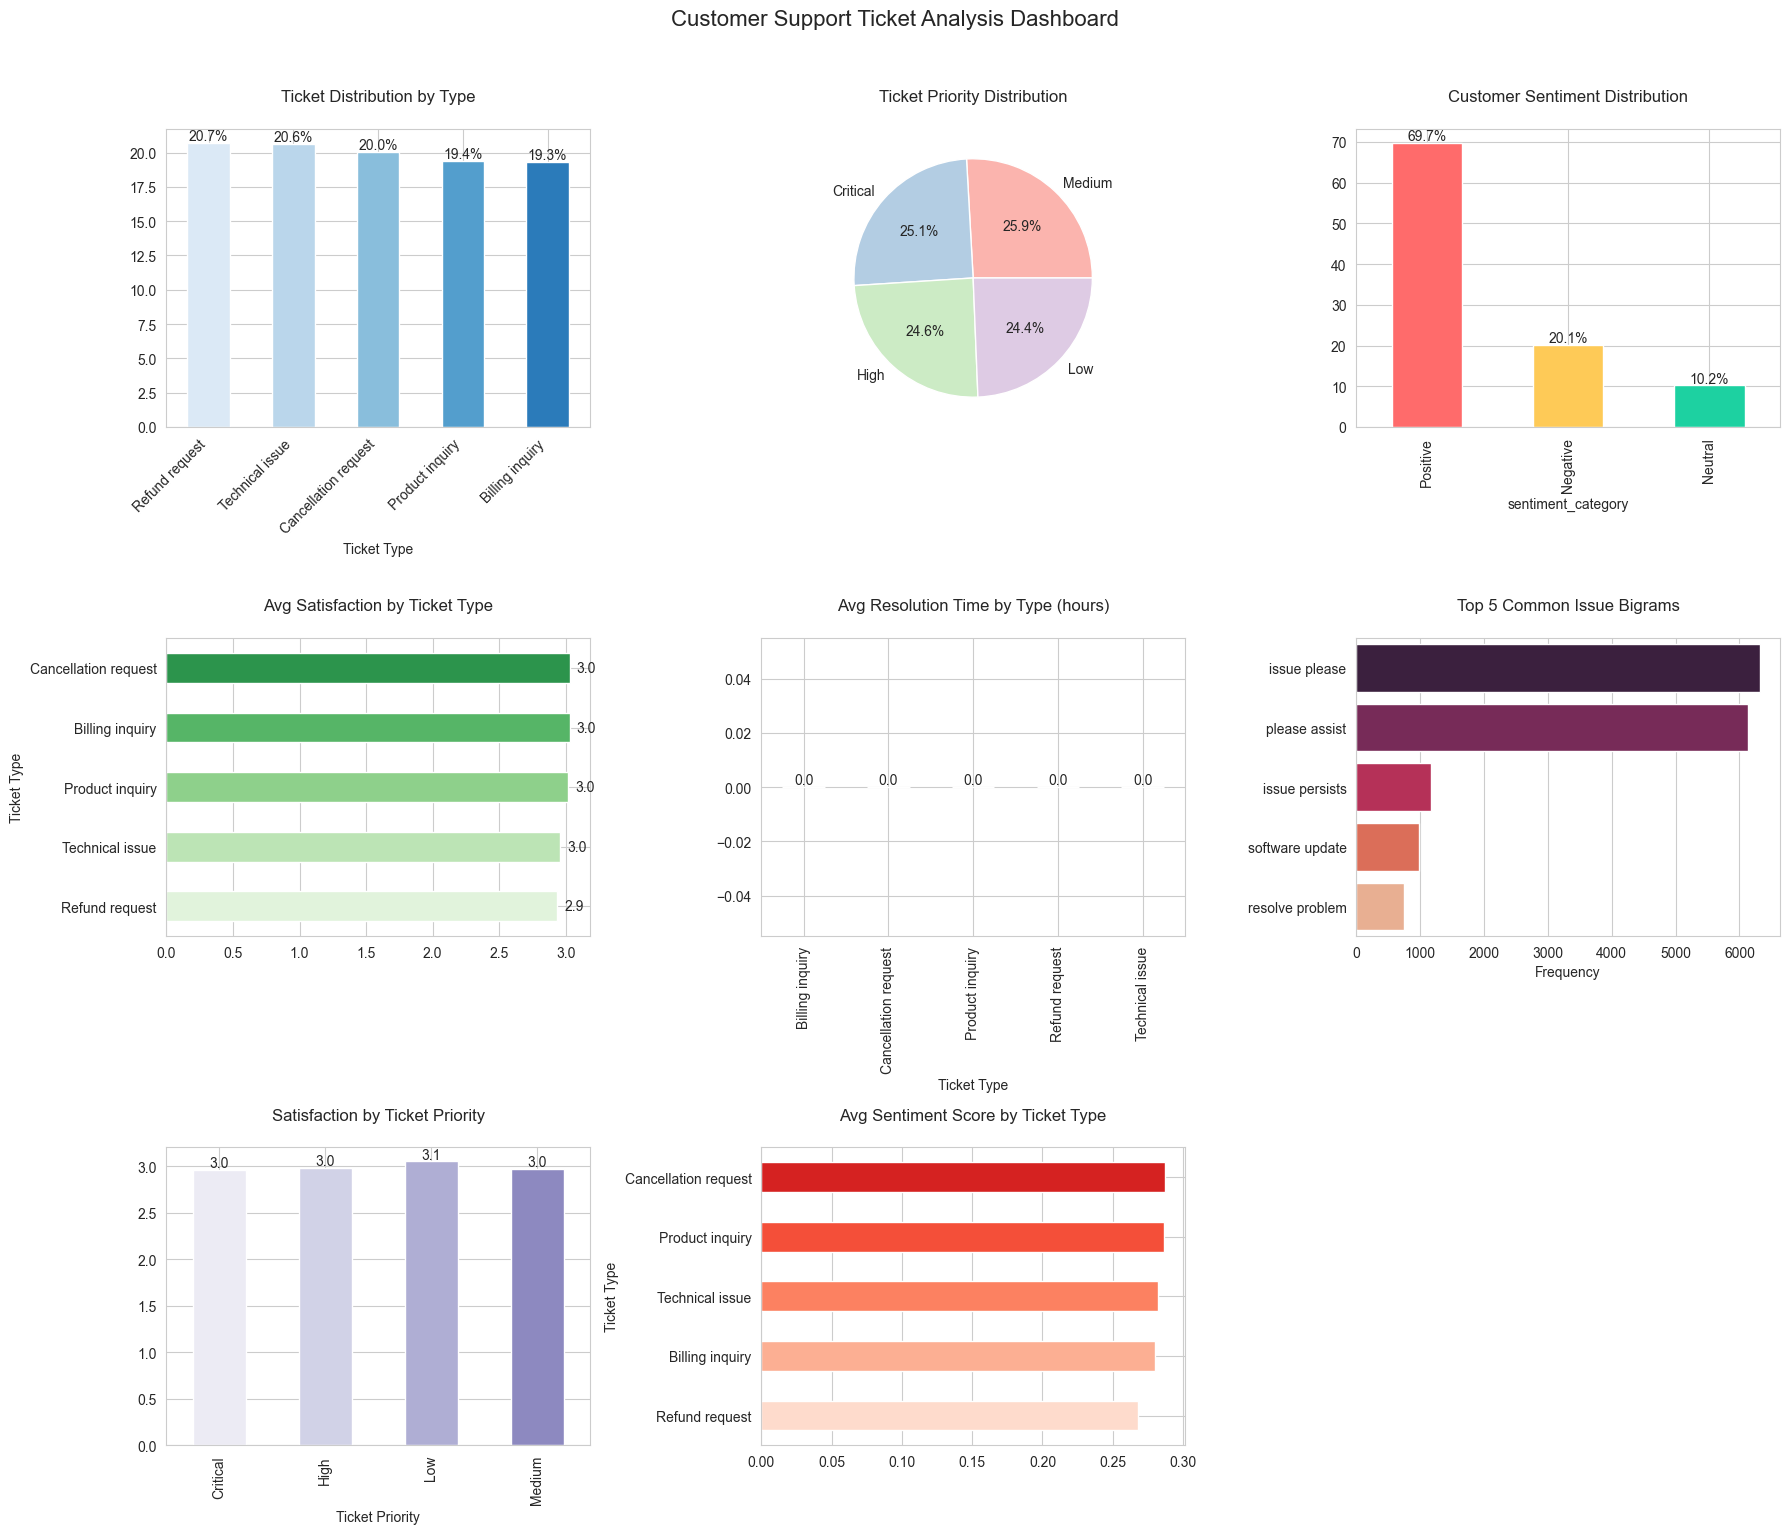

               CUSTOMER SUPPORT TICKETS ANALYSIS REPORT               

Date Generated: 2025-05-04 23:08:40
Total Tickets Analyzed: 8,469

----------------------------------------------------------------------
                       KEY PERFORMANCE METRICS                        
----------------------------------------------------------------------

Average Resolution Time: nan hours
Median Resolution Time: nan hours
Average First Response Time: nan hours

Average Customer Satisfaction: 3.0/5
SLA Compliance Rate (≤24h resolution): 0.0%

Average Words per Ticket Description: 20.3

----------------------------------------------------------------------
                     TICKET DISTRIBUTION ANALYSIS                     
----------------------------------------------------------------------

Ticket Types (% of total):
  - Refund request: 20.7%
  - Technical issue: 20.6%
  - Cancellation request: 20.0%
  - Product inquiry: 19.4%
  - Billing inquiry: 19.3%

Ticket Priorities (% of total):

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import ngrams, FreqDist
import nltk
import string
from datetime import datetime
from openpyxl import Workbook
from openpyxl.styles import Font
from openpyxl.utils.dataframe import dataframe_to_rows
import warnings
from textwrap import wrap
warnings.filterwarnings('ignore')

nltk.download(['vader_lexicon', 'stopwords', 'punkt', 'punkt_tab', 'wordnet'])
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()
stop_words = set(nltk.corpus.stopwords.words('english')) | set(string.punctuation)

def load_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['Date of Purchase'], infer_datetime_format=True)
    df['Ticket Description'] = df['Ticket Description'].fillna('')
    df['Ticket Type'] = df['Ticket Type'].fillna('Unknown')
    df['Ticket Priority'] = df['Ticket Priority'].fillna('Medium')
    
    if 'Time to Resolution' in df.columns:
        df['Time to Resolution'] = pd.to_numeric(df['Time to Resolution'], errors='coerce')
    if 'First Response Time' in df.columns:
        df['First Response Time'] = pd.to_numeric(df['First Response Time'], errors='coerce')
    
    return df

def analyze_text(text):
    tokens = [lemmatizer.lemmatize(w.lower()) for w in word_tokenize(str(text)) 
              if w.isalpha() and w.lower() not in stop_words]
    bigrams = list(ngrams(tokens, 2))
    trigrams = list(ngrams(tokens, 3))
    sentiment = sia.polarity_scores(str(text))['compound']
    return pd.Series({
        'cleaned_text': tokens,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'sentiment': sentiment,
        'word_count': len(tokens)
    })

def generate_insights(df):
    insights = {}
    
    # Basic metrics
    insights['total_tickets'] = len(df)
    insights['tickets_by_type'] = df['Ticket Type'].value_counts(normalize=True) * 100
    insights['tickets_by_priority'] = df['Ticket Priority'].value_counts(normalize=True) * 100
    insights['tickets_by_channel'] = df['Ticket Channel'].value_counts(normalize=True) * 100
    
    # Time-based metrics
    if 'Time to Resolution' in df.columns:
        insights['avg_resolution_time'] = df['Time to Resolution'].mean()
        insights['median_resolution_time'] = df['Time to Resolution'].median()
        insights['resolution_by_type'] = df.groupby('Ticket Type')['Time to Resolution'].mean()
        insights['sla_compliance'] = (df['Time to Resolution'] <= 24).mean() * 100
    
    if 'First Response Time' in df.columns:
        insights['avg_first_response'] = df['First Response Time'].mean()
    
    # Satisfaction metrics
    if 'Customer Satisfaction Rating' in df.columns:
        insights['avg_satisfaction'] = df['Customer Satisfaction Rating'].mean()
        insights['satisfaction_by_type'] = df.groupby('Ticket Type')['Customer Satisfaction Rating'].mean()
        insights['satisfaction_by_priority'] = df.groupby('Ticket Priority')['Customer Satisfaction Rating'].mean()
    
    # Sentiment analysis
    df['sentiment_category'] = pd.cut(df['sentiment'], bins=[-1, -0.1, 0.1, 1], 
                                  labels=['Negative', 'Neutral', 'Positive'])
    insights['sentiment_dist'] = df['sentiment_category'].value_counts(normalize=True) * 100
    insights['sentiment_by_type'] = df.groupby('Ticket Type')['sentiment'].mean()
    
    # Text analysis
    insights['avg_word_count'] = df['word_count'].mean()
    all_bigrams = [bigram for sublist in df['bigrams'] for bigram in sublist]
    insights['top_bigrams'] = FreqDist(all_bigrams).most_common(5)
    
    return insights

def create_visualizations(insights, df):
    plt.figure(figsize=(18, 15))
    sns.set_style("whitegrid")
    plt.suptitle("Customer Support Ticket Analysis Dashboard", fontsize=16, y=1.02)
    
    # Ticket Type Distribution
    plt.subplot(3, 3, 1)
    ax = insights['tickets_by_type'].plot(kind='bar', color=sns.color_palette("Blues"))
    plt.title('Ticket Distribution by Type', pad=20)
    plt.xticks(rotation=45, ha='right')
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', xytext=(0, 5), 
                   textcoords='offset points')
    
    # Ticket Priority Distribution
    plt.subplot(3, 3, 2)
    insights['tickets_by_priority'].plot(kind='pie', autopct='%1.1f%%', 
                                       colors=sns.color_palette("Pastel1"),
                                       textprops={'fontsize': 10})
    plt.title('Ticket Priority Distribution', pad=20)
    plt.ylabel('')
    
    # Sentiment Distribution
    plt.subplot(3, 3, 3)
    ax = insights['sentiment_dist'].plot(kind='bar', color=['#ff6b6b', '#feca57', '#1dd1a1'])
    plt.title('Customer Sentiment Distribution', pad=20)
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', xytext=(0, 5), 
                   textcoords='offset points')
    
    # Satisfaction by Type (if available)
    if 'satisfaction_by_type' in insights:
        plt.subplot(3, 3, 4)
        ax = insights['satisfaction_by_type'].sort_values().plot(kind='barh', color=sns.color_palette("Greens"))
        plt.title('Avg Satisfaction by Ticket Type', pad=20)
        for p in ax.patches:
            ax.annotate(f"{p.get_width():.1f}", 
                       (p.get_width(), p.get_y() + p.get_height() / 2.), 
                       ha='left', va='center', xytext=(5, 0), 
                       textcoords='offset points')
    
    # Resolution Time by Type (if available)
    if 'resolution_by_type' in insights:
        plt.subplot(3, 3, 5)
        ax = insights['resolution_by_type'].sort_values().plot(kind='bar', color=sns.color_palette("Oranges"))
        plt.title('Avg Resolution Time by Type (hours)', pad=20)
        for p in ax.patches:
            ax.annotate(f"{p.get_height():.1f}", 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', xytext=(0, 5), 
                       textcoords='offset points')
    
    # Top Bigrams
    plt.subplot(3, 3, 6)
    top_bigrams = pd.DataFrame(insights['top_bigrams'], columns=['Bigram', 'Count'])
    top_bigrams['Bigram'] = top_bigrams['Bigram'].apply(lambda x: ' '.join(x))
    ax = sns.barplot(x='Count', y='Bigram', data=top_bigrams, palette="rocket")
    plt.title('Top 5 Common Issue Bigrams', pad=20)
    plt.xlabel('Frequency')
    plt.ylabel('')
    
    # Additional visualizations
    if 'satisfaction_by_priority' in insights:
        plt.subplot(3, 3, 7)
        ax = insights['satisfaction_by_priority'].plot(kind='bar', color=sns.color_palette("Purples"))
        plt.title('Satisfaction by Ticket Priority', pad=20)
        for p in ax.patches:
            ax.annotate(f"{p.get_height():.1f}", 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', xytext=(0, 5), 
                       textcoords='offset points')
    
    if 'sentiment_by_type' in insights:
        plt.subplot(3, 3, 8)
        ax = insights['sentiment_by_type'].sort_values().plot(kind='barh', color=sns.color_palette("Reds"))
        plt.title('Avg Sentiment Score by Ticket Type', pad=20)
        plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

def generate_report(insights, df):
    # Create a styled report
    report = []
    
    # Header
    report.append("="*70)
    report.append("CUSTOMER SUPPORT TICKETS ANALYSIS REPORT".center(70))
    report.append("="*70)
    report.append(f"\nDate Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report.append(f"Total Tickets Analyzed: {insights['total_tickets']:,}")
    
    # Key Metrics
    report.append("\n" + "-"*70)
    report.append("KEY PERFORMANCE METRICS".center(70))
    report.append("-"*70)
    
    if 'avg_resolution_time' in insights:
        report.append(f"\nAverage Resolution Time: {insights['avg_resolution_time']:.1f} hours")
        report.append(f"Median Resolution Time: {insights['median_resolution_time']:.1f} hours")
    
    if 'avg_first_response' in insights:
        report.append(f"Average First Response Time: {insights['avg_first_response']:.1f} hours")
    
    if 'avg_satisfaction' in insights:
        report.append(f"\nAverage Customer Satisfaction: {insights['avg_satisfaction']:.1f}/5")
    
    if 'sla_compliance' in insights:
        report.append(f"SLA Compliance Rate (≤24h resolution): {insights['sla_compliance']:.1f}%")
    
    report.append(f"\nAverage Words per Ticket Description: {insights['avg_word_count']:.1f}")
    
    # Ticket Distribution
    report.append("\n" + "-"*70)
    report.append("TICKET DISTRIBUTION ANALYSIS".center(70))
    report.append("-"*70)
    
    report.append("\nTicket Types (% of total):")
    for typ, pct in insights['tickets_by_type'].items():
        report.append(f"  - {typ}: {pct:.1f}%")
    
    report.append("\nTicket Priorities (% of total):")
    for pri, pct in insights['tickets_by_priority'].items():
        report.append(f"  - {pri}: {pct:.1f}%")
    
    # Sentiment Analysis
    report.append("\n" + "-"*70)
    report.append("CUSTOMER SENTIMENT ANALYSIS".center(70))
    report.append("-"*70)
    
    report.append("\nSentiment Distribution:")
    report.append(f"  - Positive: {insights['sentiment_dist']['Positive']:.1f}%")
    report.append(f"  - Neutral: {insights['sentiment_dist']['Neutral']:.1f}%")
    report.append(f"  - Negative: {insights['sentiment_dist']['Negative']:.1f}%")
    
    if 'sentiment_by_type' in insights:
        report.append("\nAverage Sentiment by Ticket Type:")
        for typ, score in insights['sentiment_by_type'].sort_values(ascending=False).items():
            sentiment = "Positive" if score > 0.1 else "Neutral" if score > -0.1 else "Negative"
            report.append(f"  - {typ}: {score:.2f} ({sentiment})")
    
    # Common Issues
    report.append("\n" + "-"*70)
    report.append("TOP CUSTOMER ISSUES".center(70))
    report.append("-"*70)
    
    report.append("\nMost Common Bigrams (word pairs):")
    for i, (bigram, count) in enumerate(insights['top_bigrams'], 1):
        report.append(f"  {i}. {' '.join(bigram)} (appears {count} times)")
    
    # Recommendations
    report.append("\n" + "-"*70)
    report.append("RECOMMENDATIONS".center(70))
    report.append("-"*70)
    
    # Generate dynamic recommendations based on insights
    if 'sentiment_dist' in insights and insights['sentiment_dist']['Negative'] > 20:
        report.append("\n* Action Item: Negative sentiment is elevated (>20%). Review negative tickets for common patterns.")
    
    if 'sla_compliance' in insights and insights['sla_compliance'] < 90:
        report.append(f"\n* Action Item: SLA compliance rate is {insights['sla_compliance']:.1f}%, below the 90% target. Investigate bottlenecks.")
    
    most_common_type = insights['tickets_by_type'].idxmax()
    report.append(f"\n* Focus Area: '{most_common_type}' tickets represent {insights['tickets_by_type'].max():.1f}% of volume. Consider:")
    report.append(f"  - Process optimization for this ticket type")
    report.append(f"  - Additional training for support staff")
    report.append(f"  - Potential self-service options")
    
    report.append("\n" + "="*70)
    report.append("END OF REPORT".center(70))
    report.append("="*70)
    
    # Print the report
    print("\n".join(report))
    
    # Also return as DataFrame for export
    summary_df = pd.DataFrame({
        'Metric': [
            'Total Tickets', 
            'Avg Resolution Time (hrs)', 
            'Median Resolution Time (hrs)',
            'Avg First Response (hrs)',
            'Avg Satisfaction (1-5)',
            'SLA Compliance (%)',
            'Avg Word Count',
            'Positive Sentiment (%)',
            'Neutral Sentiment (%)',
            'Negative Sentiment (%)'
        ],
        'Value': [
            insights['total_tickets'],
            insights.get('avg_resolution_time', 'N/A'),
            insights.get('median_resolution_time', 'N/A'),
            insights.get('avg_first_response', 'N/A'),
            insights.get('avg_satisfaction', 'N/A'),
            insights.get('sla_compliance', 'N/A'),
            insights['avg_word_count'],
            insights['sentiment_dist']['Positive'],
            insights['sentiment_dist']['Neutral'],
            insights['sentiment_dist']['Negative']
        ]
    }).dropna()
    
    return summary_df

def export_to_excel(df, insights, filename="support_analysis_report.xlsx"):
    wb = Workbook()
    ws = wb.active
    ws.title = "Summary"
    
    # Write summary data
    summary_df = generate_report(insights, df)  # This creates our DataFrame
    for r in dataframe_to_rows(summary_df, index=False, header=True):
        ws.append(r)
    
    # Add ticket type distribution
    ws.append([])
    ws.append(["Ticket Type Distribution"])
    types_df = insights['tickets_by_type'].reset_index()
    types_df.columns = ['Ticket Type', 'Percentage']
    for r in dataframe_to_rows(types_df, index=False, header=True):
        ws.append(r)
    
    # Add priority distribution
    ws.append([])
    ws.append(["Ticket Priority Distribution"])
    pri_df = insights['tickets_by_priority'].reset_index()
    pri_df.columns = ['Priority', 'Percentage']
    for r in dataframe_to_rows(pri_df, index=False, header=True):
        ws.append(r)
    
    # Add sentiment analysis
    ws.append([])
    ws.append(["Sentiment Analysis"])
    sent_df = insights['sentiment_dist'].reset_index()
    sent_df.columns = ['Sentiment', 'Percentage']
    for r in dataframe_to_rows(sent_df, index=False, header=True):
        ws.append(r)
    
    # Add top bigrams
    ws.append([])
    ws.append(["Top 5 Common Bigrams"])
    bigrams_df = pd.DataFrame(insights['top_bigrams'], columns=['Bigram', 'Count'])
    bigrams_df['Bigram'] = bigrams_df['Bigram'].apply(lambda x: ' '.join(x))
    for r in dataframe_to_rows(bigrams_df, index=False, header=True):
        ws.append(r)
    
    # Formatting
    for cell in ws[1]:
        cell.font = Font(bold=True)
    
    # Save the file
    wb.save(filename)
    print(f"\nReport successfully exported to {filename}")

# Main execution
file_path = r"C:\Users\avina\Downloads\archive (12)\customer_support_tickets.csv"
df = load_data(file_path)
text_features = df['Ticket Description'].apply(analyze_text)
df = pd.concat([df, text_features], axis=1)
insights = generate_insights(df)

# Generate and display the enhanced report
summary_df = generate_report(insights, df)

# Create visualizations
create_visualizations(insights, df)

# Export to Excel
export_to_excel(df, insights)